In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# Model prototyping

The goal of this notebook is to get a feel for the performance of the two different types of models to be trained.
Specifically, comparison will be made between a naive baseline model, a ridge regression model, and a convolutional neural network model. Because this notebook is simply prototyping, a very small subset of the available data will be used; a single 
feature's time series for a single country, the United States. This single feature is all that will be available to the CNN and Ridge regression models; because eventually the feature data used in the regression is much larger than that used in the CNN training, this might be an unfair comparison.

The main issue for using a very small subset of data is that I believe it will affect the CNN more than the regression, because
the small number of samples influences how well the specific architecture will perform. Regardless I will press on and continue this testing. 

Both will use mean squared error as their loss function, unfortunately this means that I have to use RidgeCV, which means I need to provide my own folds in order to respect time ordering.

Much like how in regression we want to include multiple days of information for prediction,  it may also be benefitial to convolve multiple frames together for the CNN?

In [2]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def normalize_Xy_splits(splits, feature_range=(0., 0.5), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 0.5)
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    for i in range(1, X_train.shape[0]+1):
        # find the minima and maxima of all features for all countries, ranging up to current frame and 
        # each time step in the frame. 
        up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
        up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
        latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,n_countries,frame_size,1))
        if i == 1:
            frame_min_array = latest_min_array
            frame_max_array = latest_max_array
        else:
            frame_min_array = np.concatenate((frame_min_array, 
                                                   latest_min_array)
                                                  ,axis=0)
            frame_max_array = np.concatenate((frame_max_array, 
                                                   latest_max_array)
                                                  ,axis=0)

    # frame_min_array = np.tile(frame_min_array, (1, n_countries, 1, 1))
    # frame_max_array = np.tile(frame_max_array, (1, n_countries, 1, 1))

    minmax_denominator = (frame_max_array-frame_min_array)
    minmax_denominator[np.where(minmax_denominator==0)]=1
    X_train_scaled = (max_-min_)*(X_train - frame_min_array) / minmax_denominator
    # Use the latest min and max for test scaling.

    latest_minmax_denominator = latest_max_array - latest_min_array
    latest_minmax_denominator[np.where(latest_minmax_denominator==0)] = 1
    X_validate_scaled = (max_- min_)*((X_validate - np.tile(latest_min_array,(n_validation_frames,1,1,1)))
                                        / np.tile(latest_minmax_denominator,(n_validation_frames,1,1,1)))
    X_test_scaled = (max_- min_)*((X_test - np.tile(latest_min_array,(n_test_frames,1,1,1))) 
                                        / np.tile(latest_minmax_denominator,(n_test_frames,1,1,1)))
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 

    train_norm_arrays =  (frame_max_array, frame_min_array, minmax_denominator)
    validate_and_test_norm_arrays = (latest_max_array,latest_min_array,latest_minmax_denominator)

    return scaled_splits, train_norm_arrays, validate_and_test_norm_arrays

def flatten_Xy_splits(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat )
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None

should have been average/taking min max over countries as well as time. 

be sure to check the definition of y when multiple countries. I think this is the definition from when using chronological data.

Things that have been discussed with mike that might need to be changed. predicting log(y) as opposed to y. 
using MAE instead of MSE. 
using pooling or not. 
filter numbers. 
Using one country, one feature. 

In [3]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [4]:
data = global_data[global_data.location=='United States'].reset_index(drop=True)
# data = global_data
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
# data.loc[:, 'time_index'] += 1

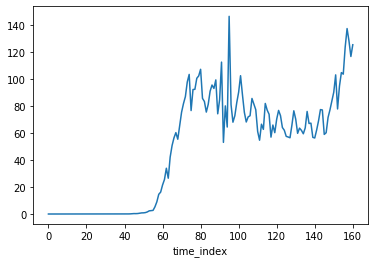

In [5]:
per_country_plot(data, 'new_cases_per_million',legend=False)

# CNN model


Late to the party of why CNN model misbehaves sometimes; problem lies in the activation functions + dense layers; most common complication is that the output layer's weight is w<=0, meaning that upon multiplication with ReLU, it can only provide 0. 

In [6]:
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 1:]
model_data =  model_data#.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
model_data = model_data.iloc[:, new_cases_index].to_frame(); new_cases_index=0
n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [7]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)
# if need to supply folds for sklearn CV regression functions.
(X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
(train_indices, validate_indices, test_indices) = indices

scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = splits

X_cnn_train_model = np.concatenate(X_cnn_train.reshape(X_cnn_train.shape[0], X_cnn_train.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_validate_model = np.concatenate(X_cnn_validate.reshape(X_cnn_validate.shape[0], X_cnn_validate.shape[1], -1), axis=0)[:,:,np.newaxis]
X_cnn_test_model = np.concatenate(X_cnn_test.reshape(X_cnn_test.shape[0], X_cnn_test.shape[1], -1), axis=0)[:,:,np.newaxis]
y_cnn_train_model = y_cnn_train.ravel()
y_cnn_validate_model = y_cnn_validate.ravel()
y_cnn_test_model = y_cnn_test.ravel()



X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


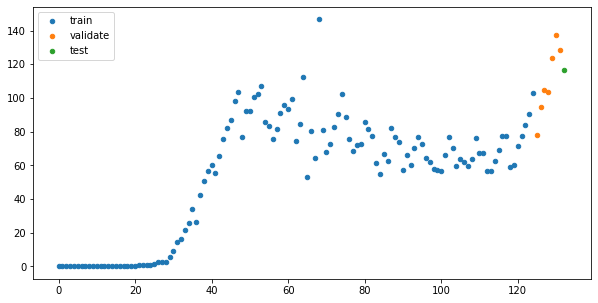

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:, 0, -1, new_cases_index], s=40, color='r')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,0,-1,new_cases_index], s=20, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,0,-1,new_cases_index], s=20, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,0,-1,new_cases_index], s=20, label='test')
# ax.plot(np.log(data.new_cases_per_million.values[start_date-1:-1]+1), color='k', alpha=0.2)
# ax.plot(y, color='k')
plt.legend()
_ = plt.show()

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

# Rescale to 0.5 to 1 to account for new maximums. How does this even help?        

In [68]:
epochs = 2000
learning_rate = 0.0001
kernel = 4
N = 8
FC = 8
batch_size = X_cnn_train.shape[0]

f1, f2 = 64, 8
k1, k2 = 4, 4

cnn_model = Sequential()
# kernel_initializer0=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
#                 kernel_constraint=non_neg(),
#                  activation='relu',
#                 kernel_initializer=kernel_initializer0
                )
         )

cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))
# kernel_initializer1=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=0,
#                                 dtype=float)

cnn_model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 use_bias=False,
#                  kernel_constraint=non_neg(),

#                  activation='relu',
#                 kernel_initializer=kernel_initializer1
#                   use_bias=False
                )
         )


cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Activation('relu'))
cnn_model.add(Flatten())

# kernel_initializer2=RandomUniform(minval=0.0, 
#                                  maxval= 1.0,
#                                  seed=2,
#                                 dtype=float)

cnn_model.add(Dense(cnn_model.output.shape[1], 
                activation='relu',
                use_bias=False,
#                  kernel_constraint=non_neg(),
#                 kernel_initializer=kernel_initializer2
               )
         )

kernel_initializer3=RandomUniform(minval=0.0, 
                                 maxval= 1.0,
                                 seed=0,
                                dtype=float)

cnn_model.add(Dense(1, 
                    activation='relu',
                    use_bias=False,
                     kernel_constraint=non_neg(),
#                     kernel_initializer=kernel_initializer3
                   ))
cnn_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

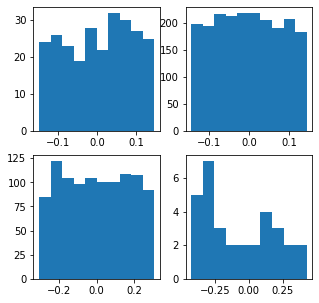

In [69]:
fig, axes = plt.subplots(2,2, figsize=(5,5))
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [ ]:
history = cnn_model.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
          batch_size=batch_size, verbose=1)

Train on 125 samples, validate on 7 samples
Epoch 1/2000
125/125 [==============================] - 0s 2ms/sample - loss: 4287.0986 - val_loss: 12585.6357
Epoch 2/2000
125/125 [==============================] - 0s 56us/sample - loss: 3848.5242 - val_loss: 12560.1553
Epoch 3/2000
125/125 [==============================] - 0s 64us/sample - loss: 3837.7410 - val_loss: 12530.6650
Epoch 4/2000
125/125 [==============================] - 0s 64us/sample - loss: 3825.2107 - val_loss: 12499.0361
Epoch 5/2000
125/125 [==============================] - 0s 64us/sample - loss: 3811.8755 - val_loss: 12466.0566
Epoch 6/2000
125/125 [==============================] - 0s 56us/sample - loss: 3798.0503 - val_loss: 12432.1895
Epoch 7/2000
125/125 [==============================] - 0s 64us/sample - loss: 3783.7441 - val_loss: 12397.9238
Epoch 8/2000
125/125 [==============================] - 0s 56us/sample - loss: 3769.2256 - val_loss: 12363.8857
Epoch 9/2000
125/125 [==============================] - 0s 64

Epoch 74/2000
125/125 [==============================] - 0s 56us/sample - loss: 2691.7329 - val_loss: 9819.9268
Epoch 75/2000
125/125 [==============================] - 0s 64us/sample - loss: 2672.4338 - val_loss: 9771.4893
Epoch 76/2000
125/125 [==============================] - 0s 56us/sample - loss: 2653.0437 - val_loss: 9722.7451
Epoch 77/2000
125/125 [==============================] - 0s 56us/sample - loss: 2633.5532 - val_loss: 9673.6631
Epoch 78/2000
125/125 [==============================] - 0s 56us/sample - loss: 2613.9773 - val_loss: 9624.2324
Epoch 79/2000
125/125 [==============================] - 0s 56us/sample - loss: 2594.3174 - val_loss: 9574.4111
Epoch 80/2000
125/125 [==============================] - 0s 56us/sample - loss: 2574.5842 - val_loss: 9524.3076
Epoch 81/2000
125/125 [==============================] - 0s 56us/sample - loss: 2554.7861 - val_loss: 9473.8389
Epoch 82/2000
125/125 [==============================] - 0s 64us/sample - loss: 2534.9141 - val_loss: 94

Epoch 147/2000
125/125 [==============================] - 0s 56us/sample - loss: 1207.8517 - val_loss: 5526.2505
Epoch 148/2000
125/125 [==============================] - 0s 56us/sample - loss: 1190.9132 - val_loss: 5463.6362
Epoch 149/2000
125/125 [==============================] - 0s 56us/sample - loss: 1174.2653 - val_loss: 5401.0366
Epoch 150/2000
125/125 [==============================] - 0s 56us/sample - loss: 1157.9142 - val_loss: 5338.4297
Epoch 151/2000
125/125 [==============================] - 0s 56us/sample - loss: 1141.8584 - val_loss: 5275.5938
Epoch 152/2000
125/125 [==============================] - 0s 56us/sample - loss: 1126.1155 - val_loss: 5211.8101
Epoch 153/2000
125/125 [==============================] - 0s 56us/sample - loss: 1110.6981 - val_loss: 5148.5503
Epoch 154/2000
125/125 [==============================] - 0s 64us/sample - loss: 1095.6012 - val_loss: 5085.8403
Epoch 155/2000
125/125 [==============================] - 0s 56us/sample - loss: 1080.8507 - val

125/125 [==============================] - 0s 56us/sample - loss: 706.5825 - val_loss: 2723.3599
Epoch 221/2000
125/125 [==============================] - 0s 56us/sample - loss: 705.2850 - val_loss: 2719.9524
Epoch 222/2000
125/125 [==============================] - 0s 56us/sample - loss: 703.9959 - val_loss: 2716.9470
Epoch 223/2000
125/125 [==============================] - 0s 56us/sample - loss: 702.7134 - val_loss: 2714.4021
Epoch 224/2000
125/125 [==============================] - 0s 56us/sample - loss: 701.4374 - val_loss: 2712.1060
Epoch 225/2000
125/125 [==============================] - 0s 56us/sample - loss: 700.2370 - val_loss: 2708.1926
Epoch 226/2000
125/125 [==============================] - 0s 64us/sample - loss: 699.0638 - val_loss: 2701.8533
Epoch 227/2000
125/125 [==============================] - 0s 64us/sample - loss: 697.9272 - val_loss: 2693.9519
Epoch 228/2000
125/125 [==============================] - 0s 56us/sample - loss: 696.8305 - val_loss: 2684.4055
Epoch 2

Epoch 294/2000
125/125 [==============================] - 0s 56us/sample - loss: 639.5265 - val_loss: 2346.2214
Epoch 295/2000
125/125 [==============================] - 0s 56us/sample - loss: 638.7740 - val_loss: 2342.5247
Epoch 296/2000
125/125 [==============================] - 0s 56us/sample - loss: 638.0242 - val_loss: 2339.6511
Epoch 297/2000
125/125 [==============================] - 0s 64us/sample - loss: 637.2936 - val_loss: 2337.5598
Epoch 298/2000
125/125 [==============================] - 0s 56us/sample - loss: 636.5538 - val_loss: 2336.1992
Epoch 299/2000
125/125 [==============================] - 0s 56us/sample - loss: 635.8047 - val_loss: 2335.5154
Epoch 300/2000
125/125 [==============================] - 0s 56us/sample - loss: 635.0558 - val_loss: 2334.3167
Epoch 301/2000
125/125 [==============================] - 0s 56us/sample - loss: 634.3147 - val_loss: 2332.6584
Epoch 302/2000
125/125 [==============================] - 0s 56us/sample - loss: 633.5684 - val_loss: 23

Epoch 368/2000
125/125 [==============================] - 0s 56us/sample - loss: 580.0947 - val_loss: 2210.8748
Epoch 369/2000
125/125 [==============================] - 0s 56us/sample - loss: 579.1912 - val_loss: 2206.9104
Epoch 370/2000
125/125 [==============================] - 0s 56us/sample - loss: 578.2859 - val_loss: 2202.9490
Epoch 371/2000
125/125 [==============================] - 0s 56us/sample - loss: 577.3782 - val_loss: 2199.0413
Epoch 372/2000
125/125 [==============================] - 0s 64us/sample - loss: 576.4677 - val_loss: 2195.7559
Epoch 373/2000
125/125 [==============================] - 0s 56us/sample - loss: 575.5508 - val_loss: 2193.0674
Epoch 374/2000
125/125 [==============================] - 0s 56us/sample - loss: 574.6304 - val_loss: 2190.2778
Epoch 375/2000
125/125 [==============================] - 0s 56us/sample - loss: 573.7145 - val_loss: 2187.4939
Epoch 376/2000
125/125 [==============================] - 0s 64us/sample - loss: 572.7985 - val_loss: 21

Epoch 442/2000
125/125 [==============================] - 0s 72us/sample - loss: 506.8598 - val_loss: 2078.6553
Epoch 443/2000
125/125 [==============================] - 0s 56us/sample - loss: 505.7601 - val_loss: 2076.3853
Epoch 444/2000
125/125 [==============================] - 0s 56us/sample - loss: 504.6640 - val_loss: 2073.7947
Epoch 445/2000
125/125 [==============================] - 0s 56us/sample - loss: 503.5812 - val_loss: 2070.8855
Epoch 446/2000
125/125 [==============================] - 0s 56us/sample - loss: 502.5030 - val_loss: 2067.4558
Epoch 447/2000
125/125 [==============================] - 0s 56us/sample - loss: 501.4308 - val_loss: 2063.6440
Epoch 448/2000
125/125 [==============================] - 0s 56us/sample - loss: 500.3520 - val_loss: 2059.7739
Epoch 449/2000
125/125 [==============================] - 0s 56us/sample - loss: 499.2693 - val_loss: 2055.8364
Epoch 450/2000
125/125 [==============================] - 0s 56us/sample - loss: 498.1832 - val_loss: 20

Epoch 516/2000
125/125 [==============================] - 0s 56us/sample - loss: 430.8605 - val_loss: 1823.8435
Epoch 517/2000
125/125 [==============================] - 0s 56us/sample - loss: 429.8817 - val_loss: 1820.7201
Epoch 518/2000
125/125 [==============================] - 0s 56us/sample - loss: 428.9036 - val_loss: 1817.7528
Epoch 519/2000
125/125 [==============================] - 0s 64us/sample - loss: 427.9260 - val_loss: 1814.9463
Epoch 520/2000
125/125 [==============================] - 0s 56us/sample - loss: 426.9487 - val_loss: 1812.3453
Epoch 521/2000
125/125 [==============================] - 0s 64us/sample - loss: 425.9716 - val_loss: 1809.9144
Epoch 522/2000
125/125 [==============================] - 0s 56us/sample - loss: 424.9945 - val_loss: 1807.6569
Epoch 523/2000
125/125 [==============================] - 0s 64us/sample - loss: 424.0176 - val_loss: 1805.5148
Epoch 524/2000
125/125 [==============================] - 0s 56us/sample - loss: 423.0417 - val_loss: 18

Epoch 590/2000
125/125 [==============================] - 0s 56us/sample - loss: 363.2113 - val_loss: 1625.2058
Epoch 591/2000
125/125 [==============================] - 0s 64us/sample - loss: 362.3872 - val_loss: 1622.7335
Epoch 592/2000
125/125 [==============================] - 0s 56us/sample - loss: 361.5660 - val_loss: 1620.2805
Epoch 593/2000
125/125 [==============================] - 0s 56us/sample - loss: 360.7481 - val_loss: 1617.8279
Epoch 594/2000
125/125 [==============================] - 0s 64us/sample - loss: 359.9328 - val_loss: 1615.3658
Epoch 595/2000
125/125 [==============================] - 0s 56us/sample - loss: 359.1202 - val_loss: 1612.8829
Epoch 596/2000
125/125 [==============================] - 0s 56us/sample - loss: 358.3118 - val_loss: 1610.4315
Epoch 597/2000
125/125 [==============================] - 0s 56us/sample - loss: 357.5039 - val_loss: 1608.0182
Epoch 598/2000
125/125 [==============================] - 0s 56us/sample - loss: 356.6985 - val_loss: 16

Epoch 664/2000
125/125 [==============================] - 0s 64us/sample - loss: 309.6449 - val_loss: 1446.3480
Epoch 665/2000
125/125 [==============================] - 0s 56us/sample - loss: 309.0209 - val_loss: 1444.1326
Epoch 666/2000
125/125 [==============================] - 0s 64us/sample - loss: 308.3978 - val_loss: 1442.0051
Epoch 667/2000
125/125 [==============================] - 0s 64us/sample - loss: 307.7759 - val_loss: 1439.8219
Epoch 668/2000
125/125 [==============================] - 0s 56us/sample - loss: 307.1568 - val_loss: 1437.5865
Epoch 669/2000
125/125 [==============================] - 0s 56us/sample - loss: 306.5401 - val_loss: 1435.4279
Epoch 670/2000
125/125 [==============================] - 0s 64us/sample - loss: 305.9259 - val_loss: 1433.3080
Epoch 671/2000
125/125 [==============================] - 0s 64us/sample - loss: 305.3143 - val_loss: 1431.1257
Epoch 672/2000
125/125 [==============================] - 0s 64us/sample - loss: 304.7057 - val_loss: 14

Epoch 738/2000
125/125 [==============================] - 0s 56us/sample - loss: 265.7196 - val_loss: 1242.2904
Epoch 739/2000
125/125 [==============================] - 0s 56us/sample - loss: 265.2557 - val_loss: 1240.9902
Epoch 740/2000
125/125 [==============================] - 0s 64us/sample - loss: 264.7954 - val_loss: 1239.3650
Epoch 741/2000
125/125 [==============================] - 0s 64us/sample - loss: 264.3405 - val_loss: 1237.4023
Epoch 742/2000
125/125 [==============================] - 0s 56us/sample - loss: 263.8898 - val_loss: 1234.8795
Epoch 743/2000
125/125 [==============================] - 0s 56us/sample - loss: 263.4419 - val_loss: 1232.0050
Epoch 744/2000
125/125 [==============================] - 0s 56us/sample - loss: 262.9962 - val_loss: 1229.0372
Epoch 745/2000
125/125 [==============================] - 0s 56us/sample - loss: 262.5556 - val_loss: 1226.3663
Epoch 746/2000
125/125 [==============================] - 0s 64us/sample - loss: 262.1147 - val_loss: 12

Epoch 812/2000
125/125 [==============================] - 0s 64us/sample - loss: 239.1516 - val_loss: 1114.4731
Epoch 813/2000
125/125 [==============================] - 0s 64us/sample - loss: 238.8580 - val_loss: 1113.0651
Epoch 814/2000
125/125 [==============================] - 0s 64us/sample - loss: 238.5657 - val_loss: 1111.6096
Epoch 815/2000
125/125 [==============================] - 0s 64us/sample - loss: 238.2731 - val_loss: 1109.9579
Epoch 816/2000
125/125 [==============================] - 0s 56us/sample - loss: 237.9819 - val_loss: 1108.1665
Epoch 817/2000
125/125 [==============================] - 0s 64us/sample - loss: 237.6912 - val_loss: 1106.3219
Epoch 818/2000
125/125 [==============================] - 0s 64us/sample - loss: 237.4012 - val_loss: 1104.5116
Epoch 819/2000
125/125 [==============================] - 0s 64us/sample - loss: 237.1117 - val_loss: 1102.9203
Epoch 820/2000
125/125 [==============================] - 0s 64us/sample - loss: 236.8216 - val_loss: 11

Epoch 886/2000
125/125 [==============================] - 0s 64us/sample - loss: 217.2980 - val_loss: 988.1847
Epoch 887/2000
125/125 [==============================] - 0s 56us/sample - loss: 217.0369 - val_loss: 986.6879
Epoch 888/2000
125/125 [==============================] - 0s 56us/sample - loss: 216.7765 - val_loss: 985.1764
Epoch 889/2000
125/125 [==============================] - 0s 64us/sample - loss: 216.5166 - val_loss: 983.6302
Epoch 890/2000
125/125 [==============================] - 0s 72us/sample - loss: 216.2573 - val_loss: 982.0397
Epoch 891/2000
125/125 [==============================] - 0s 64us/sample - loss: 215.9987 - val_loss: 980.4035
Epoch 892/2000
125/125 [==============================] - 0s 64us/sample - loss: 215.7529 - val_loss: 978.5016
Epoch 893/2000
125/125 [==============================] - 0s 72us/sample - loss: 215.5099 - val_loss: 976.3309
Epoch 894/2000
125/125 [==============================] - 0s 64us/sample - loss: 215.2672 - val_loss: 973.9245
E

Epoch 960/2000
125/125 [==============================] - 0s 64us/sample - loss: 200.8687 - val_loss: 876.2578
Epoch 961/2000
125/125 [==============================] - 0s 64us/sample - loss: 200.6556 - val_loss: 875.2345
Epoch 962/2000
125/125 [==============================] - 0s 56us/sample - loss: 200.4443 - val_loss: 873.7466
Epoch 963/2000
125/125 [==============================] - 0s 64us/sample - loss: 200.2322 - val_loss: 871.8268
Epoch 964/2000
125/125 [==============================] - 0s 56us/sample - loss: 200.0199 - val_loss: 870.2050
Epoch 965/2000
125/125 [==============================] - 0s 56us/sample - loss: 199.8087 - val_loss: 868.9101
Epoch 966/2000
125/125 [==============================] - 0s 56us/sample - loss: 199.5980 - val_loss: 867.4354
Epoch 967/2000
125/125 [==============================] - 0s 56us/sample - loss: 199.3872 - val_loss: 865.8126
Epoch 968/2000
125/125 [==============================] - 0s 53us/sample - loss: 199.1768 - val_loss: 864.1888
E

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(cnn_model.get_weights()[0].ravel())
_ = ax2.hist(cnn_model.get_weights()[1].ravel())
_ = ax3.hist(cnn_model.get_weights()[2].ravel())
_ = ax4.hist(cnn_model.get_weights()[3].ravel())
plt.show()

In [ ]:
print(np.array(cnn_model.get_weights())[0].min(),
np.array(cnn_model.get_weights())[1].min(),
np.array(cnn_model.get_weights())[2].min(),
np.array(cnn_model.get_weights())[3].min())

In [ ]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

In [ ]:
y_true = y_cnn_train_model.ravel()
y_predict = cnn_model.predict(X_cnn_train_model).ravel()
model_analysis(y_true, y_train_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on training set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

In [ ]:
y_cnn_train_model.max(), y_train_naive.max(), y_predict.max()

There were 0 negative predictions
1-step MSE [Naive, CNN model] = [170.80669257142873,1030.1168956946265]
1-step R^2 [Naive, CNN model] = [0.2994526992709322,0.5442352024240946]

In [ ]:
y_true = y_cnn_validate_model.ravel()
y_predict = cnn_model.predict(X_cnn_validate_model).ravel()
model_analysis(y_true, y_validate_naive, y_predict, n_countries, title='CNN model', suptitle='Performance on validation set')
print(y_true.max(),y_train_naive.max(), y_predict.max())

In [ ]:
train_tile_shape = np.array(np.array(X_cnn_train.shape)/np.array(frame_denom.shape),int)
minmax_inverse_train = X_train - (((X_cnn_train / 0.5) * np.tile(frame_denom, train_tile_shape)) + np.tile(frame_min, train_tile_shape))


validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
minmax_inverse_validate = X_validate - (((X_cnn_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))


test_tile_shape = np.array(np.array(X_cnn_test.shape)/np.array(latest_denom.shape),int)
minmax_inverse_test = X_test - (((X_cnn_test / 0.5) * np.tile(latest_denom, test_tile_shape)) + np.tile(latest_min, test_tile_shape))
print(np.linalg.norm(minmax_inverse_train),np.linalg.norm(minmax_inverse_validate),np.linalg.norm(minmax_inverse_test))

Time index to X relationship.

    Last frame, last day of X is time_index() - n_days_into_future
    last frame, first day is time_index() - n_days_into_future - frame_size
    first frame, first day is start_date-frame_size
    first frame, last day is start_date


Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.
The "missing" data point at the end is because it is in the prediction variable y, and not in X.

At first the following plot looks wrong because y looks like it is 1-day behind but this is only because I am
not providing the time values. I.e. the 5th value of y is actually the 6th value of X. 

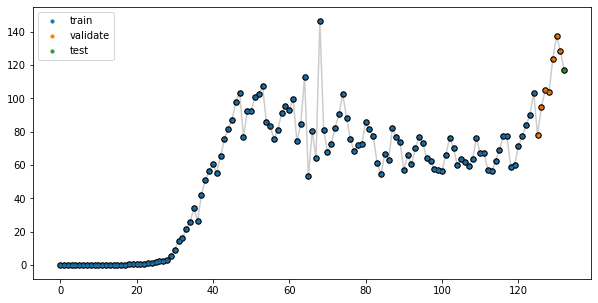

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_train)), X_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
ax.plot(data[data.location=='United States'].new_cases_per_million.values[frame_size-1:-1], color='k',alpha=0.2)
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

# Regression


In [ ]:
r_data = pd.read_csv('regression_data.csv', index_col=0)
r_data = r_data[r_data.location == 'United States']

I only use 1 feature in the CNN model, I understand that regression and CNN are fundamentally different but does
this mean I should only be using 1 feature for a fair baseline comparison?

In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
#
new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [ ]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)

y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

In [ ]:
validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
X_validate - (((X_cnn_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))
(latest_max, latest_min, latest_denom) = latest_minmax

In [ ]:
print(X_regression_train.max(),X_regression_validate.max(),X_regression_test.max())

In [ ]:
print(X_regression_train.shape,X_regression_validate.shape,X_regression_test.shape)

In [ ]:
print(y_regression_train.shape,y_regression_validate.shape,y_regression_test.shape)

Each row is a frame of frame_size days of new_cases_per_million data for a single country. So the number of rows equals
n_countries times frame_size

This transformation (slicing off last row) is because X_regression is both training and validation
data to be sliced by the train, validation indices passed to Ridge CV. i.e. the holdout set is being held out.

In [ ]:
X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [ ]:
y_predict_train = regression_model.predict(X_regression_train).ravel()

model_analysis( y_regression[train_indices].ravel(), y_train_naive, y_predict_train, 
               n_countries, title='Ridge regression model', suptitle='Performance on training set')

In [ ]:
y_predict_validate = regression_model.predict(X_regression_validate).ravel()
model_analysis( y_regression_validate.ravel(), y_validate_naive, y_predict_validate, n_countries,title='Ridge regression model', suptitle='Performance on validation set')

# scaled single feature

In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[r_data.time_index >= first_day]
# r_model_data = r_data.new_cases_per_million.apply(lambda x : np.log(x+1)).to_frame().copy(); new_cases_index=0
r_model_data = r_data.new_cases_per_million.to_frame().copy(); new_cases_index=0
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [ ]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

In [ ]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax

(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = scaled_splits



In [ ]:
train_tile_shape = np.array(np.array(X_regression_train.shape) / np.array(frame_denom.shape),int)
minmax_inverse_train = X_train - (((X_regression_train / 0.5) * np.tile(frame_denom, train_tile_shape)) + np.tile(frame_min, train_tile_shape))
np.linalg.norm(minmax_inverse_train)

In [ ]:
validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(latest_denom.shape),int)
minmax_inverse_validate = X_validate - (((X_regression_validate / 0.5) * np.tile(latest_denom,validate_tile_shape)) + np.tile(latest_min,validate_tile_shape))
np.linalg.norm(minmax_inverse_validate)

In [ ]:
test_tile_shape = np.array(np.array(X_regression_test.shape)/np.array(latest_denom.shape),int)
minmax_inverse_test = X_test - (((X_regression_test / 0.5) * np.tile(latest_denom, test_tile_shape)) + np.tile(latest_min, test_tile_shape))
np.linalg.norm(minmax_inverse_test)

In [ ]:
flat_splits = flatten_Xy_splits(scaled_splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [ ]:
y_predict_train = regression_model.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

In [ ]:
y_predict_validate = regression_model.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# "All" feature prediction

In [ ]:
# n_prune = 2
# mae_list_naive = []
# r2_list_naive = []
# mae_list_predict = []
# r2_list_predict = []
# # data = data[r_data.time_index >= first_day]
# new_cases_index = column_search(r_model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
# n_countries = r_data.location.nunique()
# target_data = r_data.new_cases_per_million
# time_index = r_data.time_index
# frame_size = 28
# start_date = 2*frame_size #+ time_index.min()
# # start_date = 50
# n_validation_frames = 7
# n_test_frames = 1
# n_days_into_future = 1
# train_or_test = 'train'


n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
r_model_data = r_data.iloc[:,2:].copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(r_model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = r_data.location.nunique()
target_data = r_data.new_cases_per_million
time_index = r_data.time_index.astype(int)
frame_size = 28
start_date = frame_size #+ time_index.min()
# start_date = 50
n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

In [ ]:
X, y = create_Xy(r_model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames,model_type='ridge')
(train_indices, validate_indices, test_indices) = indices

(X_train, y_train, X_validate,
 y_validate, X_test, y_test) = splits

In [ ]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index]
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index]
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index]
# y_train_naive = (np.exp(X_for_naive_slicing[train_indices, last_day_new_cases_index])-1).ravel()
# y_validate_naive =  (np.exp(X_for_naive_slicing[validate_indices, last_day_new_cases_index])-1).ravel()
# y_test_naive =  (np.exp(X_for_naive_slicing[test_indices, last_day_new_cases_index])-1).ravel()

# The normalization is alot easier if I split into train, validate, test but this makes other parts more annoying
scaled_splits, frame_minmax, latest_minmax =  normalize_Xy_splits(splits, feature_range=(0,0.5), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)

(latest_max, latest_min, latest_denom) = latest_minmax
(frame_max, frame_min, frame_denom) = frame_minmax

In [ ]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
new_cases_indices = np.ravel_multi_index([list(range(frame_size)),[new_cases_index]],(frame_size, n_features))

new_cases_indices

In [ ]:
plt.plot(X_regression_train[:,new_cases_indices][:,0])

To ensure that there is no time pollution going on, look at the first and last rows of the training data to ensure
that they have the correct days.

In [ ]:
flat_splits = flatten_Xy_splits(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
regression_model = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = regression_model.fit(X_regression, y_regression)

In [ ]:
# The first frame should have time values from 0 to 27.
r_model_data.new_cases_per_million.iloc[:28].values-X_regression_train[0, new_cases_indices]

In [ ]:
# The last row or last frame, should have values from time_index.max()-1-n_test_frames-n_validation_frames-frame_size to time_index.max()-1-n_test_frames-n_validation_frames
(r_model_data.new_cases_per_million.iloc[-28-n_test_frames-n_validation_frames-1:-n_test_frames-n_validation_frames-1].values
 -X_regression_train[-1, new_cases_indices])

In [ ]:
y_predict_train = regression_model.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

In [ ]:
y_predict_validate = regression_model.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

# Final predictions for comparison

In [ ]:
y_naive = y_test_naive
y_true = y_test
y_predict_r = regression_model.predict(X_regression_test)
y_predict_c = cnn_model.predict(X_cnn_test_model)

In [ ]:
model_analysis(y_true, y_naive, y_predict_c, n_countries, title='Ridge', suptitle='Unscaled predictor validation set performance')

In [ ]:
model_analysis(y_true, y_naive, y_predict_r, n_countries, title='CNN', suptitle='Scaled predictor validation set performance')